# GRIP @ The Sparks Foundation

## Data Science and Business Analytics

### Stock Market Prediction using Numerical and Textual Analysis - By Sabyasachi Seal

<hr>

## Importing the libraries

In [295]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from keras.layers import Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime
from sklearn import metrics 
import pandas as pd 
import numpy as np
import math
import re

## Loading and Testing Stock Market Dataset

In [296]:
df_prices = pd.read_csv('Datasets/stockprices.csv')
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,26.010000,26.379999,25.860001,25.900000,24.324486,55900
1,2017-03-02,25.830000,25.920000,25.660000,25.770000,24.202393,41800
2,2017-03-03,25.780001,26.070000,25.459999,25.780001,24.211786,70400
3,2017-03-06,25.680000,25.889999,25.440001,25.830000,24.258745,42600
4,2017-03-07,25.700001,25.879999,25.549999,25.840000,24.268139,45600


## Loading and Testing News Dataset

In [297]:
cols = ['Date', 'Category', 'News']
df_news = pd.read_csv("Datasets/news.csv", names=cols)
df_news = df_news.dropna(axis=0, how='any')
df_news

,Date,Category,News
0,20170101,life-style.beauty,Look-ing ahead
1,20170101,life-style.health-fitness.weight-loss,Genie in a diet
2,20170101,life-style.health-fitness.de-stress,17 ideas for 2017
3,20170101,life-style.health-fitness.de-stress,I started living my life to my highest potenti...
4,20170101,life-style.home-garden,Hygge up your home
...,...,...,...
873610,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
873611,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
873612,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
873613,20201231,removed,Govt extends deadline for use of FASTag till F...


## Cleaning Data - Dropping Unwanted Values

In [298]:
df_news = df_news.drop_duplicates('Date', keep='first').sort_index()
df_news = df_news.reset_index()
df_news

,index,Date,Category,News
0,0,20170101,life-style.beauty,Look-ing ahead
1,84,20170102,life-style.health-fitness.de-stress,Destress plan for the first Monday of 2017
2,784,20170103,city.bareilly,State opposition dismisses Samajwadi Party feu...
3,1483,20170104,tv.news.hindi,Rudra Soni ready to go bald for TV; not Bollyw...
4,2183,20170105,life-style.home-garden,Decoding Buddhist prayer flags
...,...,...,...,...
1456,871121,20201227,entertainment.bengali.movies.news,#BigInterview! Dhritiman Chatterjee: Nobody da...
1457,871620,20201228,astrology.horoscope,Horoscope Today; 28 December 2020: Check astro...
1458,872118,20201229,city.bareilly,Man recovers charred remains of 'thief' from h...
1459,872617,20201230,astrology.numerology-tarot,Numerology Readings 30 December 2020: Predicti...


## Storing City Data

In [299]:
city_data = df_news[df_news['Category'].str.contains('^city\.[a-z]+$', regex=True)]
city_data

,index,Date,Category,News
2,784,20170103,city.bareilly,State opposition dismisses Samajwadi Party feu...
5,2883,20170106,city.bareilly,Will stay bachelor to serve Akhilesh; says thr...
6,3582,20170107,city.mysuru,Helpdesk to aid bizmen get Udyog Aadhaar Memor...
9,5682,20170110,city.lucknow,Mulayam Singh calls off January 5 convention
12,7782,20170113,city.kochi,Vidya Balan opts out of biopic on Madhavikutty
...,...,...,...,...
1444,865132,20201215,city.nagpur,1;147 RT-PCR tests in a day; only 3 found +ve ...
1447,866631,20201218,city.ahmedabad,Cops; panch witnesses sniffed suspects' mouths...
1448,867130,20201219,city.mumbai,Rally champion only crowned if half WRC season...
1452,869128,20201223,city.vadodara,Sawmill in Makarpura GIDC gutted; none hurt


## Extracting City Data

In [300]:
city_split = pd.DataFrame(columns=['City_Name'])
city_split['City_Name'] = city_data.Category.str.split('.',expand=True)[1]
city_data = pd.concat([city_data,city_split],axis=1)
city_data.drop(columns=['Category'],axis=1, inplace=True)
city_data.reset_index(inplace=True)
city_data.drop(['level_0','index'],axis=1, inplace=True)
city_data

,Date,News,City_Name
0,20170103,State opposition dismisses Samajwadi Party feu...,bareilly
1,20170106,Will stay bachelor to serve Akhilesh; says thr...,bareilly
2,20170107,Helpdesk to aid bizmen get Udyog Aadhaar Memor...,mysuru
3,20170110,Mulayam Singh calls off January 5 convention,lucknow
4,20170113,Vidya Balan opts out of biopic on Madhavikutty,kochi
...,...,...,...
621,20201215,1;147 RT-PCR tests in a day; only 3 found +ve ...,nagpur
622,20201218,Cops; panch witnesses sniffed suspects' mouths...,ahmedabad
623,20201219,Rally champion only crowned if half WRC season...,mumbai
624,20201223,Sawmill in Makarpura GIDC gutted; none hurt,vadodara


## Preprocessing - Converting the 'Date' columns to Datetime

In [301]:
df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices.Date, format='%Y-%m-%d')
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,26.010000,26.379999,25.860001,25.900000,24.324486,55900
1,2017-03-02,25.830000,25.920000,25.660000,25.770000,24.202393,41800
2,2017-03-03,25.780001,26.070000,25.459999,25.780001,24.211786,70400
3,2017-03-06,25.680000,25.889999,25.440001,25.830000,24.258745,42600
4,2017-03-07,25.700001,25.879999,25.549999,25.840000,24.268139,45600
...,...,...,...,...,...,...,...
1253,2022-02-18,49.080002,49.950001,48.669998,49.500000,49.500000,130500
1254,2022-02-22,49.080002,50.540001,48.970001,49.490002,49.490002,107200
1255,2022-02-23,50.099998,50.320000,49.049999,49.480000,49.480000,125300
1256,2022-02-24,48.349998,49.709999,47.070000,48.980000,48.980000,189600


## Plotting the Data 

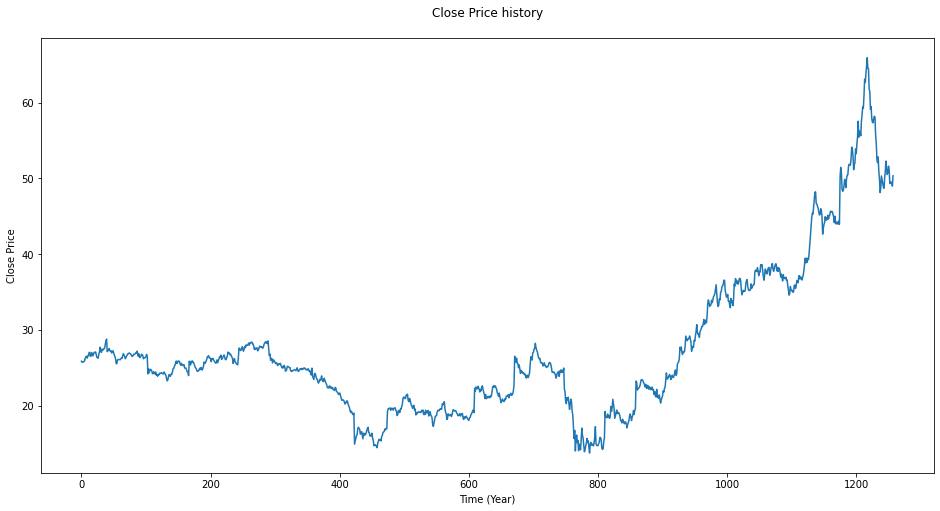

In [302]:
plt.figure(figsize=(16,8))
plt.title('Close Price history\n')
plt.xlabel('Time (Year)')
plt.ylabel('Close Price')
plt.plot(df_prices['Close'])

## Storing Closing Stock

In [303]:
def new_dataset(df_prices2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df_prices2)-look_back):
        a = df_prices2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(df_prices2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

df2 = pd.read_csv('Datasets/stockprices.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

## Data Normalization

In [304]:
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

train_size = int(len(df2) * 0.80)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

look_back = 2
trainX, trainY = new_dataset(train, look_back)
testX, testY = new_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## LSTM Neural Network Model for Numerical Analysis

In [305]:
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=10, verbose=2)

Epoch 1/500
101/101 - 3s - loss: 0.0100 - 3s/epoch - 34ms/step
Epoch 2/500
101/101 - 0s - loss: 0.0033 - 158ms/epoch - 2ms/step
Epoch 3/500
101/101 - 0s - loss: 0.0023 - 157ms/epoch - 2ms/step
Epoch 4/500
101/101 - 0s - loss: 0.0013 - 149ms/epoch - 1ms/step
Epoch 5/500
101/101 - 0s - loss: 6.1744e-04 - 140ms/epoch - 1ms/step
Epoch 6/500
101/101 - 0s - loss: 2.5656e-04 - 148ms/epoch - 1ms/step
Epoch 7/500
101/101 - 0s - loss: 1.5099e-04 - 153ms/epoch - 2ms/step
Epoch 8/500
101/101 - 0s - loss: 1.3679e-04 - 141ms/epoch - 1ms/step
Epoch 9/500
101/101 - 0s - loss: 1.3519e-04 - 143ms/epoch - 1ms/step
Epoch 10/500
101/101 - 0s - loss: 1.3549e-04 - 154ms/epoch - 2ms/step
Epoch 11/500
101/101 - 0s - loss: 1.3169e-04 - 142ms/epoch - 1ms/step
Epoch 12/500
101/101 - 0s - loss: 1.3098e-04 - 148ms/epoch - 1ms/step
Epoch 13/500
101/101 - 0s - loss: 1.3000e-04 - 151ms/epoch - 1ms/step
Epoch 14/500
101/101 - 0s - loss: 1.2974e-04 - 141ms/epoch - 1ms/step
Epoch 15/500
101/101 - 0s - loss: 1.3012e-04 - 

<h2><h2>

### The Model is now ready to make predictions.

## Making Predictions.

In [306]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### We Need to Plot the Predictions.

## Shifting Train Predictions.

In [307]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

## Shifting Test Predictions.

In [308]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(df2), :] = testPredict

## Plotting the Data

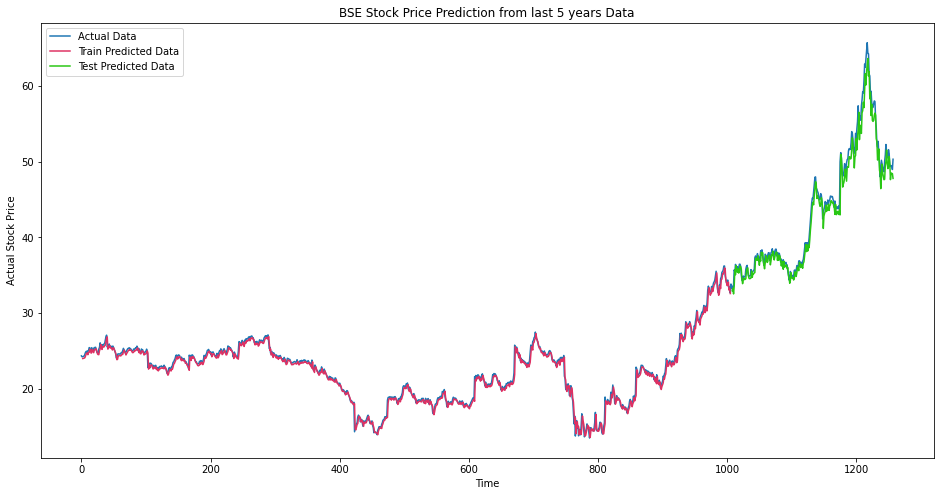

In [309]:
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(df2), label = 'Actual Data')
plt.title('BSE Stock Price Prediction from last 5 years Data')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.plot(trainPredictPlot,color='#DE3163', label = 'Train Predicted Data')
plt.plot(testPredictPlot, color='#29c714', label = 'Test Predicted Data')
plt.legend(loc='best')
plt.show()

## Root Mean Square Error

In [310]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Training  = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Testing = ",testScore," RMSE")

Training  =  0.535325686383417  RMSE
Testing =  1.3011466926658577  RMSE


<hr>

# Textual Analysis

<h2><h2>

## Headline text (News Headline) Per City

In [311]:
city_headline = city_data.groupby(['City_Name']).agg({'News':'count'})
city_headline.rename(columns={'News':'Number_of_headline_text'},inplace=True)
city_headline = city_headline.sort_values(by='Number_of_headline_text',ascending=False)
top_15_headline_city = city_headline.head(15)
top_15_headline_city

,Number_of_headline_text
City_Name,
nagpur,38
bengaluru,33
madurai,31
goa,31
trichy,31
hyderabad,29
patna,27
chennai,27
ahmedabad,25


## Top 15 Cities which have high number of headline text

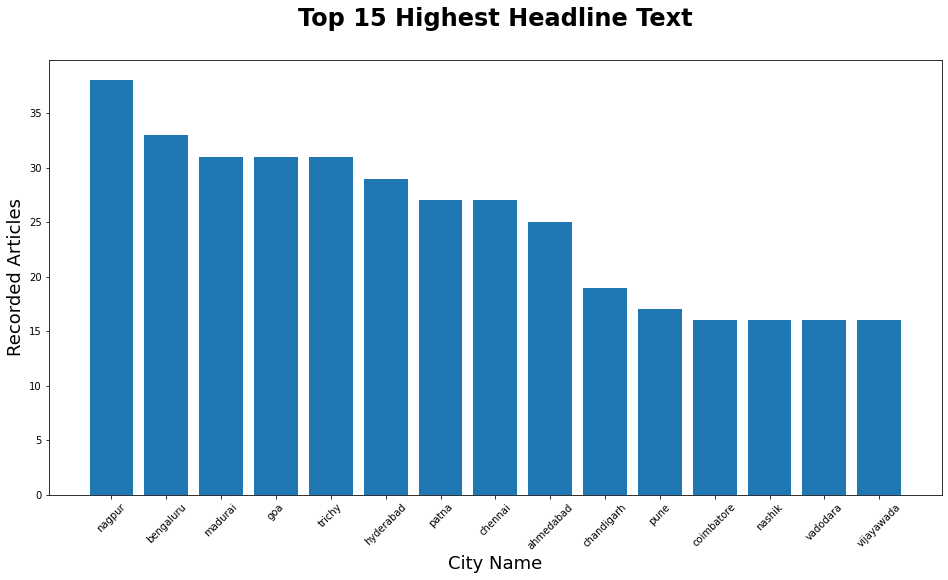

In [312]:
plt.figure(figsize=(16,8))
plt.bar(top_15_headline_city.index,height=top_15_headline_city['Number_of_headline_text'])
plt.xticks(rotation = 45)
plt.xlabel('City Name',fontsize=18)
plt.ylabel('Recorded Articles',fontsize=18)
plt.title('Top 15 Highest Headline Text\n',fontsize=24, fontweight='bold')
plt.show()

<h2></h2>

## Sentiment Analysis of Headline Text

In [313]:
def getAnalysis_polarity(headline):
    result = TextBlob(headline)
    if result.sentiment.polarity < 0:
        return 'negative'
    elif result.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'positive'

In [314]:
df_news['Result'] = np.array([getAnalysis_polarity(headline) for headline in df_news['News']])

In [315]:
final_result = df_news.groupby(['Result']).agg({'News':'count'})
final_result

,News
Result,
negative,176
neutral,848
positive,437


In [316]:
negative = (final_result.loc['negative'] / len(df_news))*100
neutral = (final_result.loc['neutral'] / len(df_news))*100
positive = (final_result.loc['positive'] / len(df_news))*100

## Printing the Percentages

In [317]:
print('Positive Headlines: ' , positive )
print('\n\nNegative Headlines: ' ,negative )
print('\n\nUnbiased Headlines: ' , str(neutral))

Positive Headlines:  News    29.91102
Name: positive, dtype: float64


Negative Headlines:  News    12.046543
Name: negative, dtype: float64


Unbiased Headlines:  News    58.042437
Name: neutral, dtype: float64


## Plotting the Results

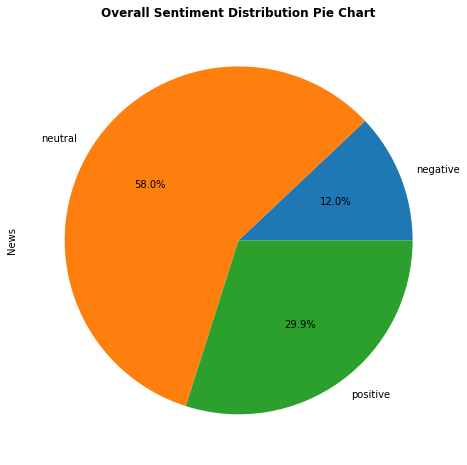

In [318]:
plt.figure(figsize=(16,8))
final_result['News'].plot.pie(autopct='%1.1f%%')
plt.title("Overall Sentiment Distribution Pie Chart",fontweight="bold")
plt.show()

<hr>

# Hybrid model for Stock Price/Perfomance Prediction

<h2></h2>

## Loading Data

In [319]:
df_prices = pd.read_csv('Datasets/stockprices.csv')
cols = ['Date', 'Category', 'News']
df_news = pd.read_csv("Datasets/news.csv", names=cols)

In [320]:
df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices.Date, format='%Y-%m-%d')

## Making Hybrid Dataset

In [321]:
hybrid_data = pd.merge(df_news, df_prices, how ='inner', on='Date')
hybrid_data

,Date,Category,News,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,life-style.relationships.man-woman,Beginner's guide to rocking sex,26.01,26.379999,25.860001,25.90,24.324486,55900
1,2017-03-01,city.indore,With only 58 PUC centres; Indore fails to curb...,26.01,26.379999,25.860001,25.90,24.324486,55900
2,2017-03-01,entertainment.hindi.bollywood,You can't miss Sonakshi Sinha's underwater pic...,26.01,26.379999,25.860001,25.90,24.324486,55900
3,2017-03-01,entertainment.tamil.movies.news,Cheran and Vijay Sethupathi to team up?,26.01,26.379999,25.860001,25.90,24.324486,55900
4,2017-03-01,entertainment.tamil.movies.news,Sonia Aggarwal to play a cop in her next,26.01,26.379999,25.860001,25.90,24.324486,55900
...,...,...,...,...,...,...,...,...,...
575066,2020-12-31,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...,31.00,31.540001,30.910000,31.32,30.921082,53200
575067,2020-12-31,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...,31.00,31.540001,30.910000,31.32,30.921082,53200
575068,2020-12-31,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...,31.00,31.540001,30.910000,31.32,30.921082,53200
575069,2020-12-31,removed,Govt extends deadline for use of FASTag till F...,31.00,31.540001,30.910000,31.32,30.921082,53200


## Performing Sentiment Analysis

In [322]:
def analysis_polarity(headline):
    result = TextBlob(headline)
    if result.sentiment.polarity < 0:
        return 'negative'
    elif result.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'positive'

In [323]:
hybrid_data['sentiment'] = np.array([analysis_polarity(headline) for headline in hybrid_data['News']])

In [324]:
senti_data = pd.get_dummies(hybrid_data['sentiment'],drop_first=True)
hybrid_data = pd.concat([hybrid_data,senti_data],axis=1)
hybrid_data.head()

,Date,Category,News,Open,High,Low,Close,Adj Close,Volume,sentiment,neutral,positive
0,2017-03-01,life-style.relationships.man-woman,Beginner's guide to rocking sex,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0
1,2017-03-01,city.indore,With only 58 PUC centres; Indore fails to curb...,26.01,26.379999,25.860001,25.9,24.324486,55900,negative,0,0
2,2017-03-01,entertainment.hindi.bollywood,You can't miss Sonakshi Sinha's underwater pic...,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0
3,2017-03-01,entertainment.tamil.movies.news,Cheran and Vijay Sethupathi to team up?,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0
4,2017-03-01,entertainment.tamil.movies.news,Sonia Aggarwal to play a cop in her next,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0


## Subjectivity and Polarity Scores

In [325]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [326]:
hybrid_data['Subjectivity'] =hybrid_data['News'].apply(getSubjectivity)
hybrid_data['Polarity'] = hybrid_data['News'].apply(getPolarity)
hybrid_data.head()

,Date,Category,News,Open,High,Low,Close,Adj Close,Volume,sentiment,neutral,positive,Subjectivity,Polarity
0,2017-03-01,life-style.relationships.man-woman,Beginner's guide to rocking sex,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00
1,2017-03-01,city.indore,With only 58 PUC centres; Indore fails to curb...,26.01,26.379999,25.860001,25.9,24.324486,55900,negative,0,0,0.65,-0.25
2,2017-03-01,entertainment.hindi.bollywood,You can't miss Sonakshi Sinha's underwater pic...,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00
3,2017-03-01,entertainment.tamil.movies.news,Cheran and Vijay Sethupathi to team up?,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00
4,2017-03-01,entertainment.tamil.movies.news,Sonia Aggarwal to play a cop in her next,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00


## Plotting the Scores

<AxesSubplot:title={'center':'News Polarity'}>

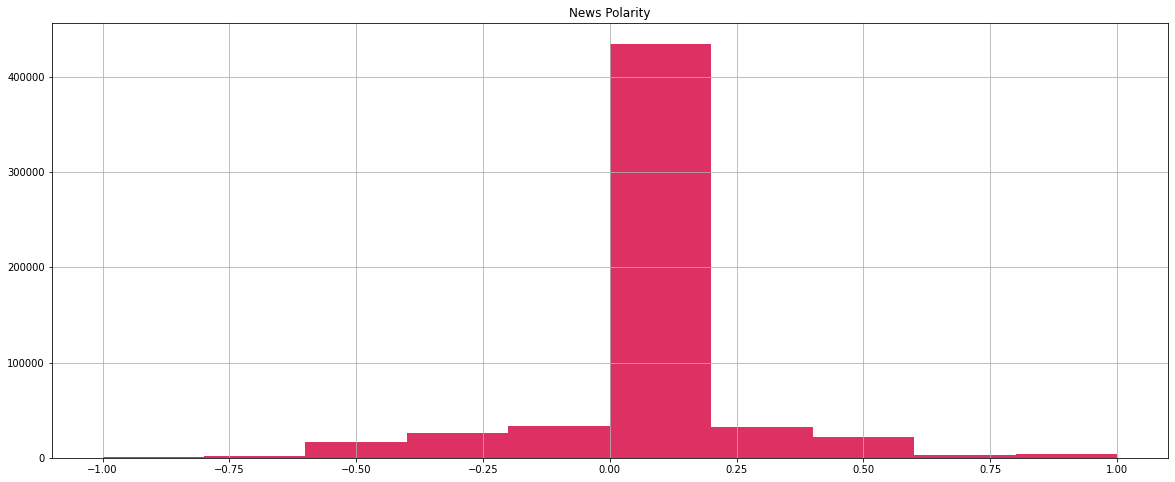

In [327]:
plt.figure(figsize = (20,8))
plt.title('News Polarity')
hybrid_data['Polarity'].hist(color = '#DE3163')

<AxesSubplot:title={'center':'News Subjectivity'}>

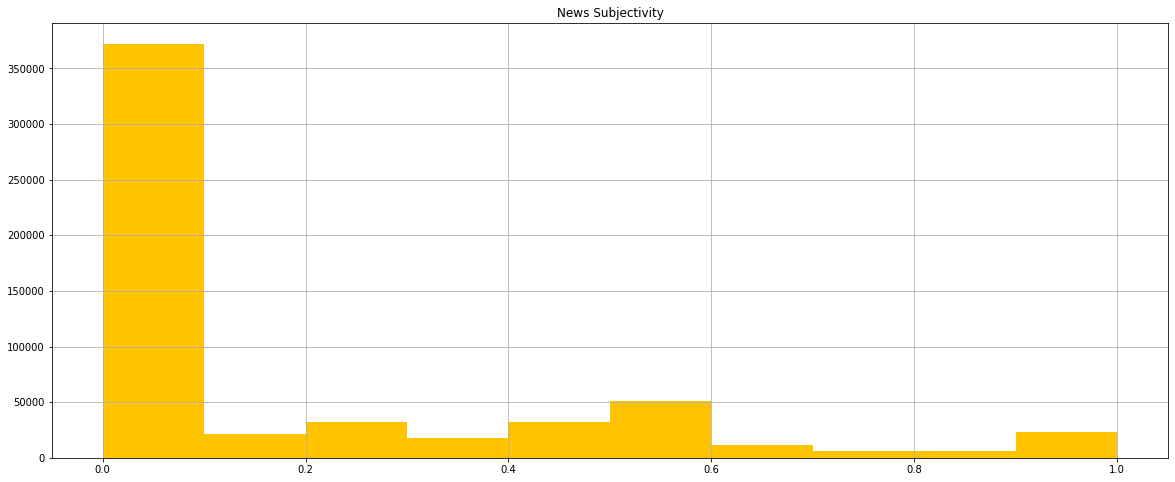

In [328]:
plt.figure(figsize = (20,8))
plt.title('News Subjectivity')
hybrid_data['Subjectivity'].hist(color = '#FFC300')

## Performing Sentiment Analysis

In [329]:
senti_int_an = SentimentIntensityAnalyzer()
hybrid_data['Compound'] = [senti_int_an.polarity_scores(v)['compound'] for v in hybrid_data['News']]
hybrid_data['Negative'] = [senti_int_an.polarity_scores(v)['neg'] for v in hybrid_data['News']]
hybrid_data['Neutral'] = [senti_int_an.polarity_scores(v)['neu'] for v in hybrid_data['News']]
hybrid_data['Positive'] = [senti_int_an.polarity_scores(v)['pos'] for v in hybrid_data['News']]
hybrid_data.head()

,Date,Category,News,Open,High,Low,Close,Adj Close,Volume,sentiment,neutral,positive,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2017-03-01,life-style.relationships.man-woman,Beginner's guide to rocking sex,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00,0.0000,0.000,1.000,0.000
1,2017-03-01,city.indore,With only 58 PUC centres; Indore fails to curb...,26.01,26.379999,25.860001,25.9,24.324486,55900,negative,0,0,0.65,-0.25,-0.4215,0.237,0.763,0.000
2,2017-03-01,entertainment.hindi.bollywood,You can't miss Sonakshi Sinha's underwater pic...,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00,0.1139,0.000,0.806,0.194
3,2017-03-01,entertainment.tamil.movies.news,Cheran and Vijay Sethupathi to team up?,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00,0.0000,0.000,1.000,0.000
4,2017-03-01,entertainment.tamil.movies.news,Sonia Aggarwal to play a cop in her next,26.01,26.379999,25.860001,25.9,24.324486,55900,neutral,1,0,0.00,0.00,0.3400,0.000,0.769,0.231


In [330]:
req_col = ['Open', 'High', 'Low', 'Volume', 'Compound', 'Negative', 'Neutral', 'Positive', 'positive']

In [331]:
new_hybrid = hybrid_data[req_col]
new_hybrid.reset_index(inplace = True)
new_hybrid.rename(columns = {'positive':'Label'}, inplace = True)
new_hybrid = new_hybrid.loc[:,~new_hybrid.columns.duplicated()]

/tmp/ipykernel_14594/4192071081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hybrid.rename(columns = {'positive':'Label'}, inplace = True)


In [332]:
new_hybrid

,index,Open,High,Low,Volume,Compound,Negative,Neutral,Positive,Label
0,0,26.01,26.379999,25.860001,55900,0.0000,0.000,1.000,0.000,0
1,1,26.01,26.379999,25.860001,55900,-0.4215,0.237,0.763,0.000,0
2,2,26.01,26.379999,25.860001,55900,0.1139,0.000,0.806,0.194,0
3,3,26.01,26.379999,25.860001,55900,0.0000,0.000,1.000,0.000,0
4,4,26.01,26.379999,25.860001,55900,0.3400,0.000,0.769,0.231,0
...,...,...,...,...,...,...,...,...,...,...
575066,575066,31.00,31.540001,30.910000,53200,0.2023,0.000,0.870,0.130,1
575067,575067,31.00,31.540001,30.910000,53200,0.2023,0.000,0.870,0.130,1
575068,575068,31.00,31.540001,30.910000,53200,0.2023,0.000,0.870,0.130,1
575069,575069,31.00,31.540001,30.910000,53200,0.1280,0.000,0.857,0.143,0


## Training and Testing the Models for Stock Price/Performance Analysis

In [333]:
X = new_hybrid.drop('Label', axis=1)    
y = new_hybrid['Label']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [334]:
np.any(np.isnan(x_train))
np.all(np.isfinite(x_train))
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())

## Logistic Regressor Model

In [335]:
logit = LogisticRegression()
logit.fit(x_train,y_train)
y_logit_pred = logit.predict(x_test)
accuracy_score(y_test,y_logit_pred)

0.8043124809807416

## Random Forest Model

In [336]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(x_train,y_train)
y_rf_pred = rf.predict(x_test)
accuracy_score(y_test,y_rf_pred)

0.7804721123331739

## Decision Tree Model

In [337]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_dt_pred = dt.predict(x_test)
accuracy_score(y_test,y_dt_pred)

0.7510933356518715

## Linear Discriminant Analyser Model

In [338]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_lda_pred = lda.predict(x_test)
accuracy_score(y_test,y_lda_pred)

0.8076250923792548

## AdaBoost Model

In [339]:
adb = AdaBoostClassifier()
adb.fit(x_train, y_train)
y_adb_pred = adb.predict(x_test)
accuracy_score(y_test,y_adb_pred)

0.8206147024301178

## Logistic Gradient Boosting Model

In [340]:
xgb = GradientBoostingClassifier()
xgb.fit(x_train, y_train)
y_xgb_pred = xgb.predict(x_test)
accuracy_score(y_test,y_xgb_pred)

0.8224492457505542

<h2></h2>

<hr>

## Plotting Accuracy Graph

In [341]:
print("Accuracy of Logistic Regression Model: ",accuracy_score(y_test,y_logit_pred)*100,"%")
print("Accuracy of Random forest Model      : ",accuracy_score(y_test,y_rf_pred)*100,"%")
print("Accuracy of Decision Tree Model      : ",accuracy_score(y_test,y_dt_pred)*100,"%")
print("Accuracy of Linear Discriminant Mode  : ",accuracy_score(y_test,y_lda_pred)*100,"%")
print("Accuracy of AdaBoost Model           : ",accuracy_score(y_test,y_adb_pred)*100,"%")
print("Accuracy of Gradient Boosting Model  : ",accuracy_score(y_test,y_xgb_pred)*100,"%")

Accuracy of Logistic Regression Model:  80.43124809807416 %
Accuracy of Random forest Model      :  78.0472112333174 %
Accuracy of Decision Tree Model      :  75.10933356518716 %
Accuracy of Linear Discriminant Mode  :  80.76250923792549 %
Accuracy of AdaBoost Model           :  82.06147024301178 %
Accuracy of Gradient Boosting Model  :  82.24492457505542 %


In [342]:
model = ["Logistic Regression", "Random Forest", "Decision Tree", "Linear Discriminant", "AdaBoost", "Gradient Boosting"]
accuracy = [accuracy_score(y_test,y_logit_pred)*100, accuracy_score(y_test,y_rf_pred)*100, accuracy_score(y_test,y_dt_pred)*100, accuracy_score(y_test,y_lda_pred)*100, accuracy_score(y_test,y_adb_pred)*100, accuracy_score(y_test,y_xgb_pred)*100]

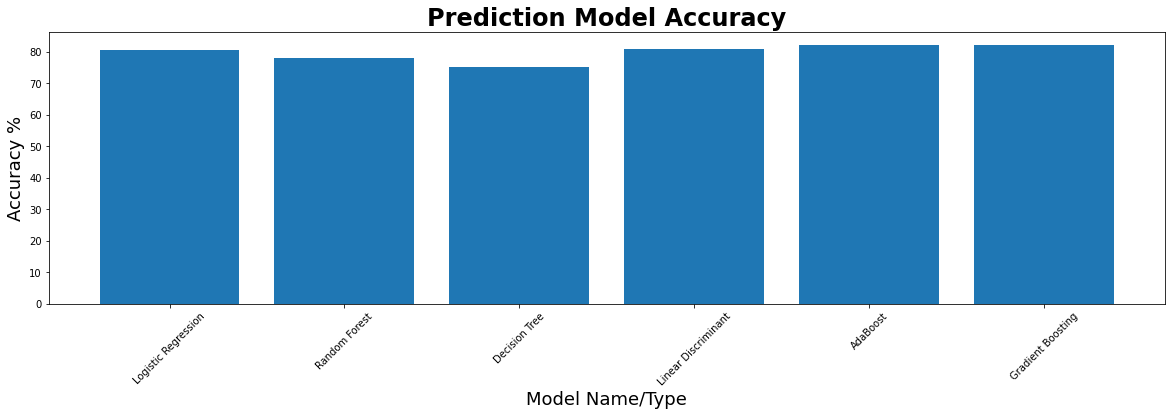

In [343]:
plt.figure(figsize=(20,5))
plt.bar(model,accuracy)
plt.xticks(rotation = 45)
plt.xlabel('Model Name/Type',fontsize=18)
plt.ylabel('Accuracy %',fontsize=18)
plt.title('Prediction Model Accuracy',fontsize=24, fontweight='bold')
plt.show()

<hr>

# Conclusion

### Here, I have used six different Neural Network models to carry out the analysis and prediction of stock price/performance and train them with Hybrid data generated from Numerical data

In [344]:
print(f"The hightest accuracy is {max(accuracy)}%")
print(f"The hightest accuracy is {model[accuracy.index(max(accuracy))]}")
print(f"At the end, we can clearly see that {model[accuracy.index(max(accuracy))]} Model gives more accuracy(== {max(accuracy)}%) as compared to all other models.It performs better on Analysis and prediction of Stock price/performance than other 5 Neural Network Models.")

The hightest accuracy is 82.24492457505542%
The hightest accuracy is Gradient Boosting
At the end, we can clearly see that Gradient Boosting Model gives more accuracy(== 82.24492457505542%) as compared to all other models.It performs better on Analysis and prediction of Stock price/performance than other 5 Neural Network Models.


<hr>